In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import welch

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

import xgboost as xgb

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
train_df = pd.read_csv('C:/Users/User/Desktop/work_projects/brain_signals/1/2024_data_simple_train.csv', sep=';')

In [3]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,class
0,-5.389356,0.069094,1.105509,1.934641,0.481477,-1.650778,-4.214753,0.207283,-0.069094,1.865546,...,-7.047620,1.306866,-4.126946,-1.105509,-4.145659,-0.621849,-6.356677,0.275130,-3.439121,0
1,-1.747946,1.024658,3.616441,2.410960,4.980161,3.480112,-0.542466,1.808220,3.194523,3.194523,...,6.630141,8.820285,5.700184,8.136991,8.317813,8.498635,7.594525,10.140328,7.140231,0
2,-1.390777,-0.327242,-8.671907,-5.563110,-7.411145,-3.176205,-0.081810,0.736294,-7.935613,-7.035698,...,6.708456,11.401762,9.528615,8.671907,8.508286,6.135783,7.117508,8.632762,8.388439,1
3,-2.808767,-7.064474,6.128218,7.915615,7.117316,3.050278,-3.745022,-8.000730,4.255707,5.957990,...,-0.680913,-7.964615,0.000000,1.617169,-0.851141,-5.362191,-1.617169,-8.642455,-1.016759,0
4,1.729156,-0.613572,-4.016105,-4.016105,-3.609284,-5.608272,2.175390,0.278896,-1.561819,-2.510065,...,-3.290975,-1.887933,-3.165065,-0.948247,-3.290975,-0.892468,-3.402533,-0.832912,-3.220592,0


In [4]:
class_distribution = train_df['class'].value_counts()
class_distribution

class
0    329
1    171
Name: count, dtype: int64

# Разбиение датафрейма на 6 датафреймов для разных каналов

In [77]:
train_dfs_raw = []

for i in range(6):
    df_new = train_df.iloc[:, i::6]

    if df_new.shape[1] > 0 and df_new.columns[-1] == 'class':
        df_new.drop('class', axis=1, inplace=True)

    df_new.rename(columns={'last_column': 'class'}, inplace=True)

    new_columns_names = [str(i) for i in range(250)]
    df_new.columns = new_columns_names


    train_dfs_raw.append(df_new)

train_df_raw_0 = train_dfs_raw[0]
train_df_raw_1 = train_dfs_raw[1]
train_df_raw_2 = train_dfs_raw[2]
train_df_raw_3 = train_dfs_raw[3]
train_df_raw_4 = train_dfs_raw[4]
train_df_raw_5 = train_dfs_raw[5]

In [78]:
train_df_raw_0.iloc[:5, -5:]


,245,246,247,248,249
0,-0.829132,-2.487395,-2.349207,-1.381886,-1.105509
1,3.073975,4.821921,6.147949,7.232881,8.136991
2,10.389926,11.780703,12.189756,10.798978,8.671907
3,8.511415,8.426300,7.234702,4.766392,1.617169
4,-3.848767,-3.625650,-3.179416,-2.175390,-0.948247


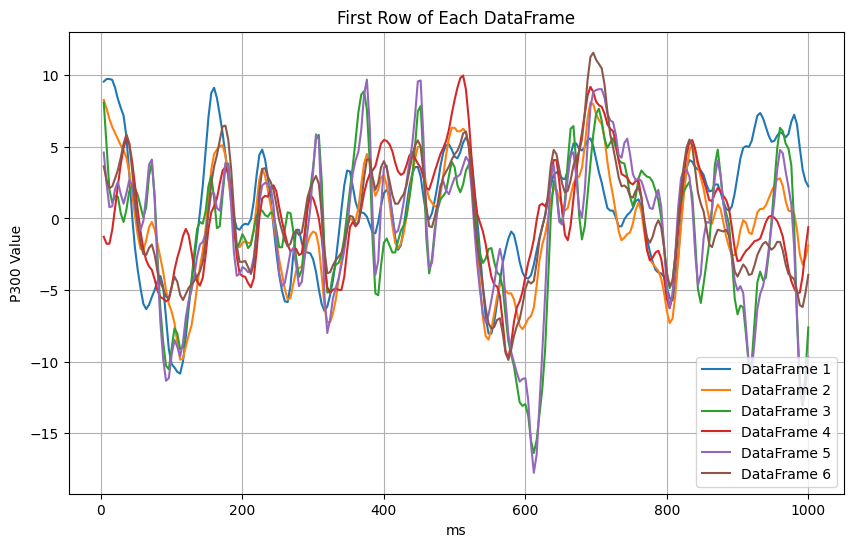

In [79]:
t_vals = np.arange(1, 251) * 4

plt.figure(figsize=(10,6))
for i, df in enumerate(train_dfs_raw):
    y_vals = df.iloc[8, :250]
    plt.plot(t_vals, y_vals, label=f'DataFrame {i+1}')

plt.xlabel('ms')
plt.ylabel('P300 Value')
plt.title('First Row of Each DataFrame')
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Применение скользящего среднего

In [80]:
window_size = 10

def smoothing_row(df, window_size):
    smoothed_df = df.apply(lambda row: row.rolling(window=window_size, min_periods=1).mean(), axis=1)
    return smoothed_df

train_dfs_raw_smooth = [smoothing_row(df, window_size) for df in train_dfs_raw]

In [9]:
train_dfs_raw_smooth[0].head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,class
0,-5.389356,-4.802055,-4.260816,-3.696546,-3.109244,-2.602552,-2.191277,-1.865546,-1.619878,-1.457890,...,2.549580,2.729225,2.874323,2.853595,2.570308,2.100467,1.623716,1.202241,0.753128,0.393838
1,-1.747946,-1.145206,-0.863927,-0.889042,-1.060823,-1.235617,-1.420745,-1.680138,-2.056013,-2.537536,...,-2.362741,-2.266303,-1.983015,-1.494795,-0.849864,-0.138630,0.584658,1.344110,2.218084,2.398906
2,-1.390777,-0.736294,-0.054540,0.531768,1.030812,1.458953,1.846579,2.229334,2.590664,2.871546,...,4.147789,4.769549,5.424032,6.152145,7.076603,8.197406,9.293666,10.029960,10.259029,9.459114
3,-2.808767,-3.276895,-3.518051,-3.425844,-2.944949,-2.170411,-1.313190,-0.521324,0.094571,0.493662,...,2.842812,3.098155,3.344986,3.600328,3.881205,4.272730,4.783415,5.251543,5.455817,5.370703
4,1.729156,1.952273,2.082425,2.189335,2.342728,2.491472,2.581782,2.649514,2.788962,3.051124,...,-4.373092,-5.036865,-5.505410,-5.739683,-5.761995,-5.611391,-5.276715,-4.769124,-4.166709,-3.530825


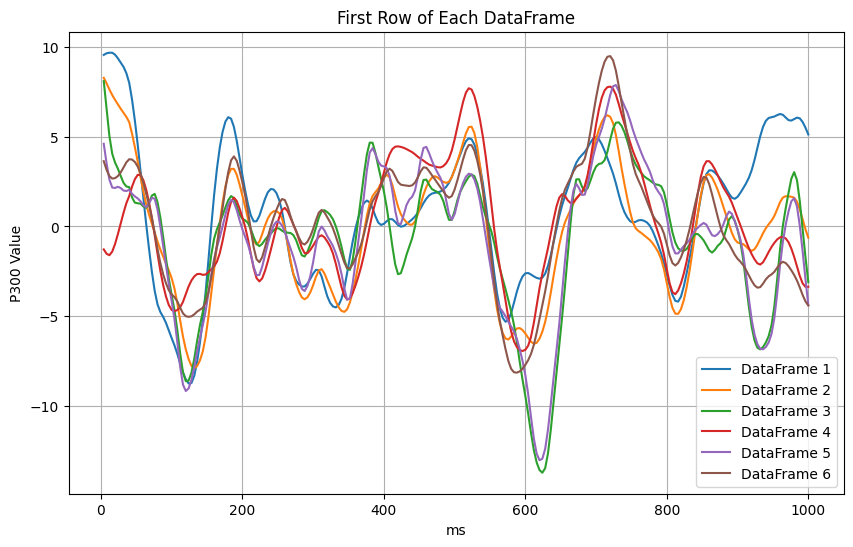

In [11]:
t_vals = np.arange(1, 251) * 4

plt.figure(figsize=(10,6))
for i, df in enumerate(train_dfs_raw_smooth):
    y_vals = df.iloc[8, :250]
    plt.plot(t_vals, y_vals, label=f'DataFrame {i+1}')

plt.xlabel('ms')
plt.ylabel('P300 Value')
plt.title('First Row of Each DataFrame')
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Обрезание сигнала [200ms - 800ms]

In [44]:
train_dfs_raw_cut = []

for df in train_dfs_raw_smooth:
    df = df.iloc[:, 50:-50]
    train_dfs_raw_cut.append(df)

train_df_raw_cut_0 = train_dfs_raw_cut[0]

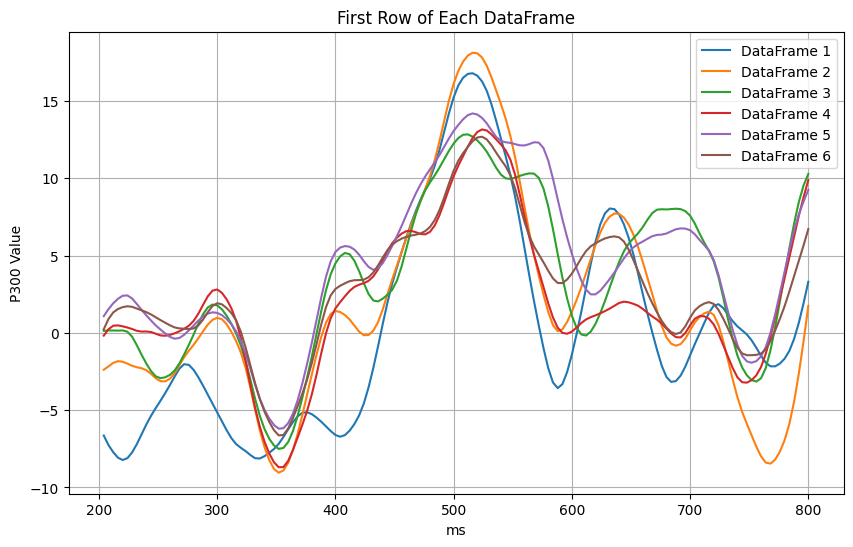

In [45]:
t_vals = np.arange(51, 201) * 4

plt.figure(figsize=(10,6))
for i, df in enumerate(train_dfs_raw_cut):
    y_vals = df.iloc[0, :150]
    plt.plot(t_vals, y_vals, label=f'DataFrame {i+1}')

plt.xlabel('ms')
plt.ylabel('P300 Value')
plt.title('First Row of Each DataFrame')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [46]:
train_df_raw_cut_0

,50,51,52,53,54,55,56,57,58,59,...,191,192,193,194,195,196,197,198,199,200
0,-6.639964,-7.254903,-7.717835,-8.070216,-8.222223,-8.104763,-7.731654,-7.192718,-6.557050,-5.928292,...,-2.162652,-2.162652,-1.983007,-1.665173,-1.160784,-0.386928,0.656396,1.920822,3.302708,4.615500
1,-3.441646,-3.972057,-4.183016,-4.128770,-3.911783,-3.610413,-3.260824,-2.863016,-2.429043,-1.964933,...,-0.536439,-0.096438,0.476165,1.103014,1.693700,2.193974,2.585755,2.911235,3.260824,3.718906
2,0.343604,0.989906,1.317148,1.243519,0.785380,0.114535,-0.531768,-0.998087,-1.259881,-1.325329,...,4.254143,4.425945,4.605928,4.753187,4.851359,4.900445,4.867721,4.663195,4.188695,3.436038
3,0.221297,-0.102137,-0.340457,-0.519196,-0.672402,-0.800073,-0.859653,-0.842630,-0.817096,-0.825607,...,4.774904,5.285588,5.609022,5.694136,5.515397,5.132383,4.621698,3.983342,3.166246,2.153388
4,1.082117,1.210409,1.466994,1.829559,2.203280,2.510065,2.800117,3.190572,3.675851,4.138819,...,2.041520,1.500461,0.937091,0.334675,-0.334675,-1.082117,-1.918806,-2.805695,-3.608916,-4.211332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,7.341668,7.641186,7.843186,7.961600,8.086980,8.247187,8.351670,8.379532,8.365601,8.261118,...,-3.434006,-3.336489,-3.322558,-3.496696,-3.803179,-4.172352,-4.666905,-5.314699,-6.032148,-6.721736
496,7.698775,7.096681,6.117275,5.057589,4.070155,3.227224,2.593018,2.207678,2.031064,2.023036,...,3.620592,3.877485,4.174518,4.511691,4.768584,4.784640,4.503663,4.126351,3.917625,3.981848
497,-2.660738,-3.746039,-4.735063,-5.514029,-6.030422,-6.354262,-6.678102,-7.054456,-7.360791,-7.474573,...,-4.411223,-4.271184,-4.157403,-4.157403,-4.227422,-4.253679,-4.148650,-3.903582,-3.544733,-3.220893
498,-7.110774,-7.297163,-7.604707,-8.014764,-8.518017,-9.095826,-9.664315,-10.111650,-10.391235,-10.521708,...,-1.845260,-2.684014,-3.662561,-4.734303,-5.787405,-6.663438,-7.297163,-7.725860,-8.014764,-8.126598


# Разработка фичей для простой (baseline) модели

In [47]:
train_df_engin = pd.DataFrame()

Максимум амплитуды

In [48]:
for i, (df_cut, df_raw) in enumerate(zip(train_dfs_raw_cut, train_dfs_raw)):

    max_values = df_cut.max(axis=1)
    mean_before_200 = df_raw.iloc[:, :50].mean(axis=1)
    max_minus_mean_vals = max_values - mean_before_200
    train_df_engin[f'max_val_ch{i+1}'] = max_minus_mean_vals


<Axes: >

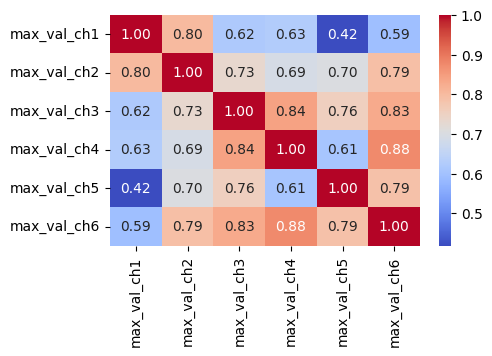

In [49]:
correlation_matrix = train_df_engin.corr(numeric_only=True)
plt.figure(figsize=(5,3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [50]:
#ch3 ~ ch4, ch6 ~ ch4
#удалить max_val_ch4
train_df_engin.drop(['max_val_ch4', 'max_val_ch6', 'max_val_ch2'], axis=1, inplace=True)
train_df_engin

,max_val_ch1,max_val_ch3,max_val_ch5
0,19.801049,16.151487,18.715699
1,8.038142,11.558144,10.509940
2,7.135507,16.990392,16.563502
3,12.639451,13.206311,10.635303
4,0.023427,7.126355,6.863193
...,...,...,...
495,-1.320664,0.562815,0.425753
496,8.135494,10.179402,9.863334
497,16.538586,16.163982,17.420610
498,13.632555,3.308420,4.549650


Время максимума на отрезке 200-500мс

In [51]:
for i, df in enumerate(train_dfs_raw_cut):
    df_raw_200_500 = df.iloc[:, :125]
    max_column_names = df_raw_200_500.idxmax(axis=1)
    max_column_names_int = max_column_names.apply(lambda col: int(col))
    train_df_engin[f'argmax200500_ch{i+1}'] = max_column_names_int
    
    

<Axes: >

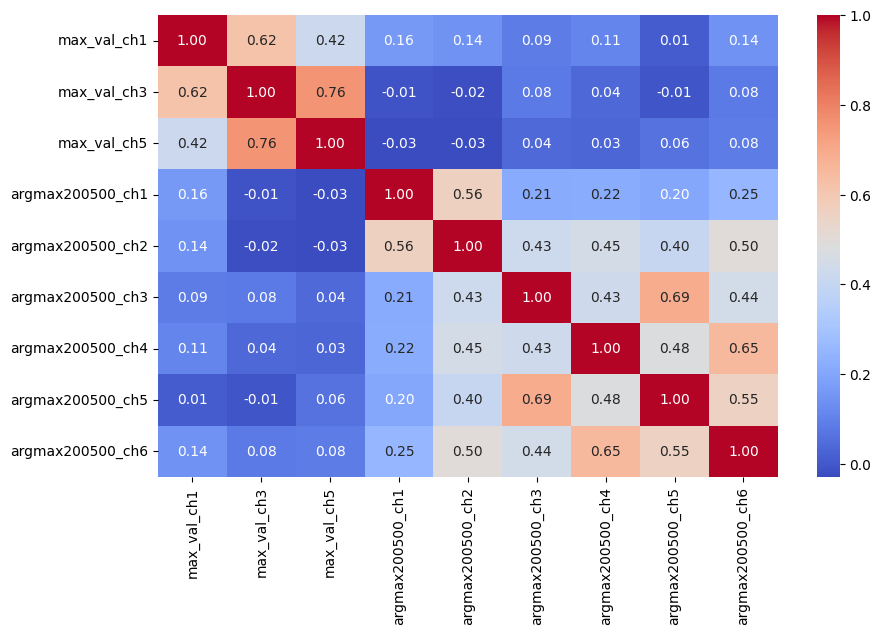

In [52]:
correlation_matrix = train_df_engin.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

Корень из среднего квадратов

In [53]:
for i, df in enumerate(train_dfs_raw_cut):
    squared_values = df ** 2
    mean_squared_values = squared_values.mean(axis=1)
    rms_values = np.sqrt(mean_squared_values)
    train_df_engin[f'rms_val_ch{i+1}'] = rms_values

In [54]:
#дропаем rms ch4
train_df_engin.drop(['rms_val_ch1', 'rms_val_ch3', 'rms_val_ch6'], axis=1, inplace=True)

<Axes: >

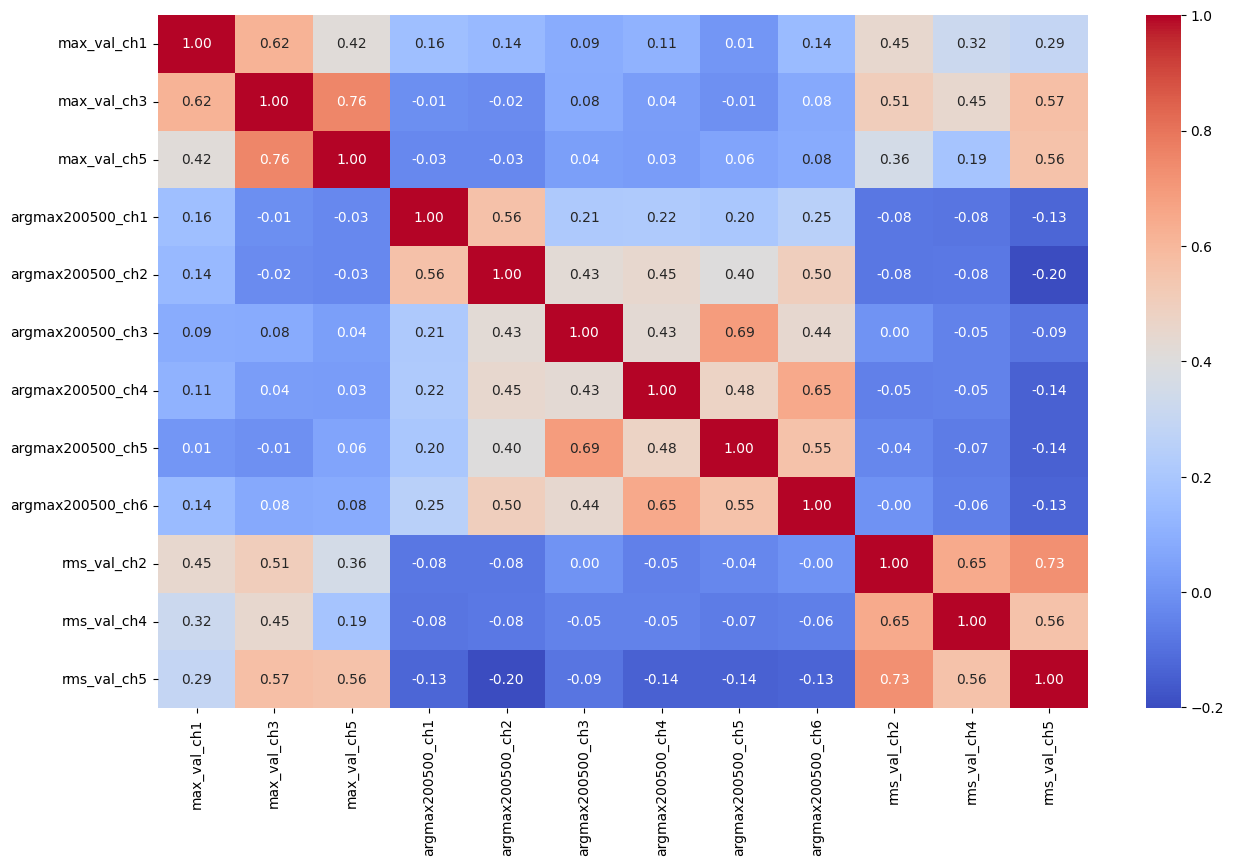

In [55]:
correlation_matrix = train_df_engin.corr(numeric_only=True)
plt.figure(figsize=(15,9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [56]:
for i, df_cut in enumerate(train_dfs_raw_cut):
    delta_band_power = []
    theta_band_power = []
    alpha_band_power = []

    # Iterate over each row in the DataFrame
    for row in df_cut.itertuples(index=False, name=None):
        # Step 1: Apply Welch's method to estimate the power spectral density
        f, Pxx = welch(row, fs=250, nperseg=256)  # fs=250 Hz, nperseg=256 for segment length

        # Step 2: Calculate band powers (Delta: 0.5-4 Hz, Theta: 4-8 Hz, Alpha: 8-12 Hz)
        delta_band = np.sum(Pxx[(f >= 0.5) & (f <= 4)])   # Delta band (0.5-4 Hz)
        theta_band = np.sum(Pxx[(f >= 4) & (f <= 8)])    # Theta band (4-8 Hz)
        alpha_band = np.sum(Pxx[(f >= 8) & (f <= 12)])   # Alpha band (8-12 Hz)


        # Append results to the lists
        delta_band_power.append(delta_band)
        theta_band_power.append(theta_band)
        alpha_band_power.append(alpha_band)

    # Step 4: Add the computed features to train_df_engin
    train_df_engin[f'delta_band_ch{i+1}'] = delta_band_power
    train_df_engin[f'theta_band_ch{i+1}'] = theta_band_power
    train_df_engin[f'alpha_band_ch{i+1}'] = alpha_band_power

c:\Users\User\Desktop\python_fall\venv\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 151, using nperseg = 151
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\User\Desktop\python_fall\venv\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 151, using nperseg = 151
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\User\Desktop\python_fall\venv\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 151, using nperseg = 151
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\User\Desktop\python_fall\venv\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 151, using nperseg = 151
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Use

In [57]:
train_df_engin

,max_val_ch1,max_val_ch3,max_val_ch5,argmax200500_ch1,argmax200500_ch2,argmax200500_ch3,argmax200500_ch4,argmax200500_ch5,argmax200500_ch6,rms_val_ch2,...,alpha_band_ch3,delta_band_ch4,theta_band_ch4,alpha_band_ch4,delta_band_ch5,theta_band_ch5,alpha_band_ch5,delta_band_ch6,theta_band_ch6,alpha_band_ch6
0,19.801049,16.151487,18.715699,128,128,127,130,128,130,6.856890,...,1.946737,15.510438,2.732940,2.173150,17.009757,1.997944,1.133302,12.199732,1.095291,1.747145
1,8.038142,11.558144,10.509940,71,82,80,85,81,85,5.970710,...,1.066176,14.564752,0.443413,0.627645,17.666124,0.871100,1.107676,14.435448,0.282570,0.822156
2,7.135507,16.990392,16.563502,146,65,73,77,77,76,8.794779,...,1.889892,13.713020,2.367403,0.657221,17.569139,4.922528,1.515801,15.503650,2.951409,1.205239
3,12.639451,13.206311,10.635303,129,149,141,150,143,150,5.633247,...,7.205980,1.768170,4.410937,3.149418,5.123435,1.561014,5.845730,3.049893,3.901835,2.722699
4,0.023427,7.126355,6.863193,66,174,174,144,174,174,3.406595,...,0.409219,1.530283,0.776082,0.198325,0.844995,1.668998,0.554683,1.460394,0.489617,0.304433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-1.320664,0.562815,0.425753,57,60,76,64,63,64,4.820045,...,0.376732,7.619908,2.262127,1.204095,8.289149,5.288359,0.309671,4.785925,0.772494,0.440976
496,8.135494,10.179402,9.863334,50,64,52,50,50,60,3.549103,...,1.777341,4.502982,1.418339,1.108265,2.076796,0.594854,1.306797,3.005202,0.241021,0.675655
497,16.538586,16.163982,17.420610,147,150,95,66,95,155,5.527101,...,1.089772,0.552682,0.347443,0.710341,2.446956,0.771211,1.395672,1.353907,0.678168,0.318199
498,13.632555,3.308420,4.549650,138,141,58,105,56,104,5.637965,...,10.359676,1.124426,5.153677,3.716888,1.263830,1.419807,5.819764,0.879698,2.710561,2.688520


In [58]:
train_df_engin.drop(['alpha_band_ch5', 'delta_band_ch5', 'theta_band_ch5', 'delta_band_ch6'], axis=1, inplace=True)

<Axes: >

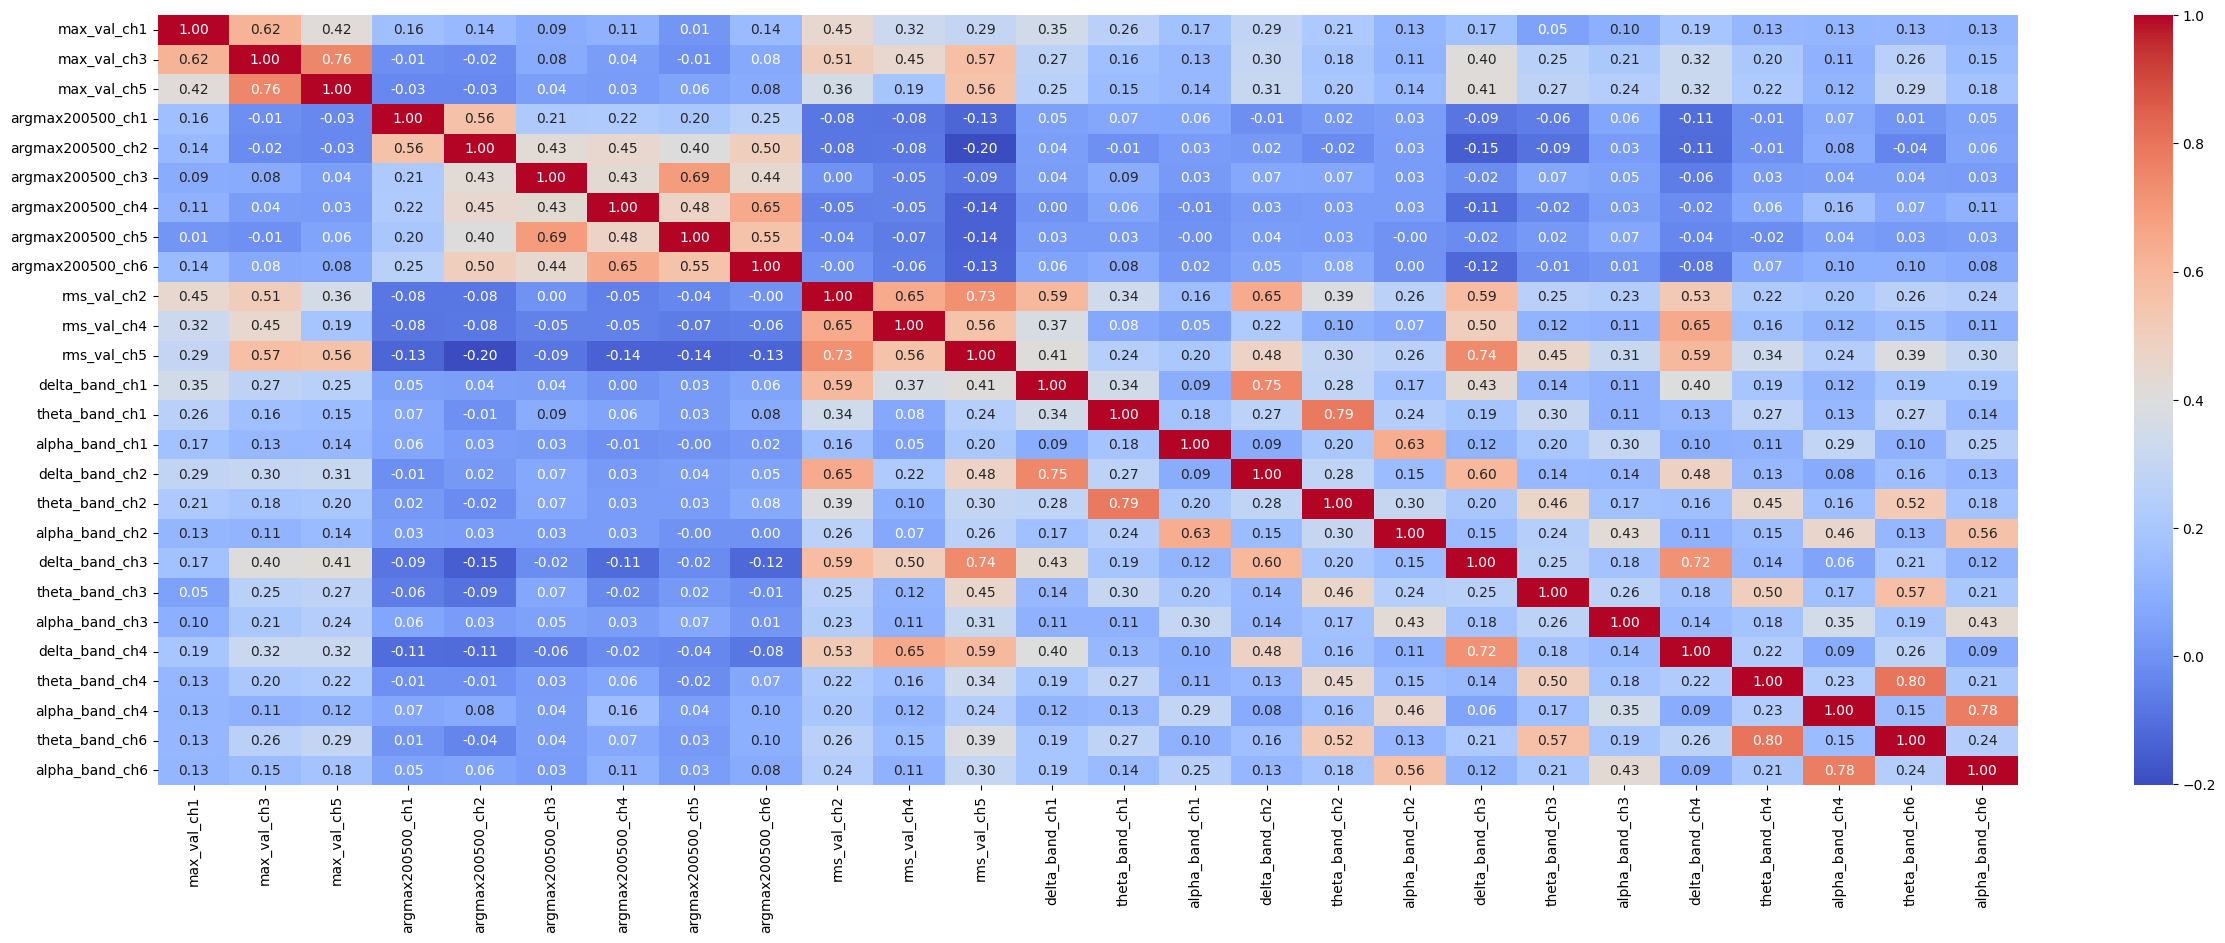

In [59]:
correlation_matrix = train_df_engin.corr(numeric_only=True)
plt.figure(figsize=(30,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [60]:
train_df_engin['class'] = train_df_raw_0.iloc[:, -1]

In [61]:
train_df_engin.tail()

,max_val_ch1,max_val_ch3,max_val_ch5,argmax200500_ch1,argmax200500_ch2,argmax200500_ch3,argmax200500_ch4,argmax200500_ch5,argmax200500_ch6,rms_val_ch2,...,alpha_band_ch2,delta_band_ch3,theta_band_ch3,alpha_band_ch3,delta_band_ch4,theta_band_ch4,alpha_band_ch4,theta_band_ch6,alpha_band_ch6,class
495,-1.320664,0.562815,0.425753,57,60,76,64,63,64,4.820045,...,1.150924,6.758541,7.699329,0.376732,7.619908,2.262127,1.204095,0.772494,0.440976,1
496,8.135494,10.179402,9.863334,50,64,52,50,50,60,3.549103,...,0.252012,2.100554,1.710214,1.777341,4.502982,1.418339,1.108265,0.241021,0.675655,0
497,16.538586,16.163982,17.420610,147,150,95,66,95,155,5.527101,...,0.328389,2.483719,0.551320,1.089772,0.552682,0.347443,0.710341,0.678168,0.318199,1
498,13.632555,3.308420,4.549650,138,141,58,105,56,104,5.637965,...,5.457693,2.256997,1.793061,10.359676,1.124426,5.153677,3.716888,2.710561,2.688520,0
499,15.303756,15.038985,13.262358,162,83,84,91,84,174,4.367673,...,0.349732,2.081930,0.870327,0.310760,0.181474,0.204521,1.190311,0.131231,0.953372,0


In [62]:
X = train_df_engin.iloc[:, :-1]
y = train_df_engin.iloc[:, -1]

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [64]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and validation data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Random Forest

In [65]:
rf_classifier = RandomForestClassifier(n_estimators=180, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_score(y_val, y_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_pred):.4f}")

Accuracy: 0.6600
Precision: 0.5000
Recall: 0.1176


In [66]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 180],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Best model evaluation
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_val)

# Re-evaluate with best model
accuracy_best_rf = accuracy_score(y_val, y_pred_best_rf)
precision_best_rf = precision_score(y_val, y_pred_best_rf)
recall_best_rf = recall_score(y_val, y_pred_best_rf)
print("Best Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_best_rf):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_best_rf):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_best_rf):.4f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 180}
Best Model Evaluation:
Accuracy: 0.6500
Precision: 0.4615
Recall: 0.1765


Лучший асс: 0.69 без второго удаления {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 175}

# XGBoost

In [67]:
# xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# xgb_model.fit(X_train, y_train)
# y_pred_xgb = xgb_model.predict(X_val)

In [68]:
# accuracy = accuracy_score(y_val, y_pred_xgb)
# print(f"XGBoost Model Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision_score(y_val, y_pred_xgb):.4f}")
# print(f"Recall: {recall_score(y_val, y_pred_xgb):.4f}")

In [69]:
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Train the model with best parameters
best_xgb_model = grid_search.best_estimator_

# Predict on validation data
y_pred_best_xgb = best_xgb_model.predict(X_val)

# Evaluate model performance
accuracy_best_xgb = accuracy_score(y_val, y_pred_best_xgb)
precision_best_xgb = precision_score(y_val, y_pred_best_xgb)
recall_best_xgb = recall_score(y_val, y_pred_best_xgb)
print(f"Best XGBoost Model Accuracy: {accuracy_best_xgb:.4f}")
print(f"Precision: {precision_score(y_val, y_pred_best_xgb):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_best_xgb):.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Model Accuracy: 0.6500
Precision: 0.4545
Recall: 0.1471


# SVM

In [70]:
# # Initialize the SVM model with RBF kernel
# svm_model = SVC(kernel='rbf', random_state=42)

# # Train the model
# svm_model.fit(X_train_scaled, y_train)

# # Predict on the validation set
# y_pred_svm = svm_model.predict(X_val_scaled)

# # Evaluate the model
# accuracy_svm = accuracy_score(y_val, y_pred_svm)
# print(f"SVM with RBF kernel Accuracy: {accuracy_svm:.4f}")
# print(f"Precision: {precision_score(y_val, y_pred_svm):.4f}")
# print(f"Recall: {recall_score(y_val, y_pred_svm):.4f}")


In [71]:
# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf']
}

# Initialize SVM with RBF kernel
svm_model = SVC(random_state=42)

# GridSearchCV to find the best parameters
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Train the model with the best parameters
best_svm_model = grid_search.best_estimator_

# Predict on validation set
y_pred_best_svm = best_svm_model.predict(X_val_scaled)

# Evaluate the model
accuracy_best_svm = accuracy_score(y_val, y_pred_best_svm)
precision_best_svm = precision_score(y_val, y_pred_best_svm)
recall_best_svm = recall_score(y_val, y_pred_best_svm)
print(f"Best SVM with RBF kernel Accuracy: {accuracy_best_svm:.4f}")
print(f"Precision: {precision_score(y_val, y_pred_best_svm):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_best_svm):.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best SVM with RBF kernel Accuracy: 0.6500
Precision: 0.3333
Recall: 0.0294


# Ансамбль

In [72]:
# ensemble_model = VotingClassifier(
#     estimators=[
#         ('svm', best_svm_model),       # Best SVM model
#         ('xgb', best_xgb_model),       # Best XGBoost model
#         ('rf', best_rf)          # Best Random Forest model
#     ],
#     voting='soft'                      # Soft voting (uses probabilities)
# )

# # Train the ensemble model on the training data
# ensemble_model.fit(X_train_scaled, y_train)

In [73]:
# # Predict on the validation set
# y_pred_ensemble = ensemble_model.predict(X_val_scaled)

# # Evaluate the ensemble model
# accuracy_ensemble = accuracy_score(y_val, y_pred_ensemble)
# print(f"Ensemble Model Accuracy: {accuracy_ensemble:.4f}")

# Logistic Regression

In [74]:
# Initialize the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],             # Regularization strength
    'solver': ['liblinear', 'lbfgs'],         # Solvers to test
    'max_iter': [100, 200, 300],              # Max iterations
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=logreg_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_logreg_model = grid_search.best_estimator_

# Predict on the validation set
y_pred_best_logreg = best_logreg_model.predict(X_val_scaled)

# Evaluate the model
accuracy_best_logreg = accuracy_score(y_val, y_pred_best_logreg)
precision_best_logreg = precision_score(y_val, y_pred_best_logreg)
recall_best_logreg = recall_score(y_val, y_pred_best_logreg)
print(f"Logistic Regression Accuracy: {accuracy_best_logreg:.4f}")
print(f"Precision: {precision_score(y_val, y_pred_best_logreg):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_best_logreg):.4f}")

# Print the best hyperparameters from GridSearchCV
print(f"Best hyperparameters: {grid_search.best_params_}")


Logistic Regression Accuracy: 0.6800
Precision: 0.5714
Recall: 0.2353
Best hyperparameters: {'C': 1, 'max_iter': 100, 'solver': 'liblinear'}


# Таблица результатов

In [75]:
results = {
    "Model": ["Random Forest", "XGBoost", "SVM", "Logistic Regression"],
    "Accuracy": [accuracy_best_rf, accuracy_best_xgb, accuracy_best_svm, accuracy_best_logreg],
    "Precision": [precision_best_rf, precision_best_xgb, precision_best_svm, precision_best_logreg],
    "Recall": [recall_best_rf, recall_best_xgb, recall_best_svm, recall_best_logreg],
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(results)

# Display the table
print(metrics_df)

                 Model  Accuracy  Precision    Recall
0        Random Forest      0.65   0.461538  0.176471
1              XGBoost      0.65   0.454545  0.147059
2                  SVM      0.65   0.333333  0.029412
3  Logistic Regression      0.68   0.571429  0.235294


1) усреднить по окну 20-50мс